In [ ]:
!pwd

In [1]:
import os
os.environ["DGLBACKEND"] = "pytorch"
import torch 
import pandas as pd
import dgl
from dgl.data import DGLDataset
import dgl.function as fn
import numpy as np

In [2]:
import matplotlib.pyplot as plt

import networkx as nx
def plot_net(net,options = None):
    netG = dgl.to_networkx(net)
    plt.figure(figsize=[15,7])
    if options != None:
        nx.draw(netG,**options)
    else:
        nx.draw(netG)

In [3]:
ds = dgl.data.CSVDataset('./toy_dataset/toy_local_attach')

Done loading data from cached files.


In [4]:
g = ds[0]

In [5]:
g.edata['w'] = torch.rand(g.num_edges(),1)

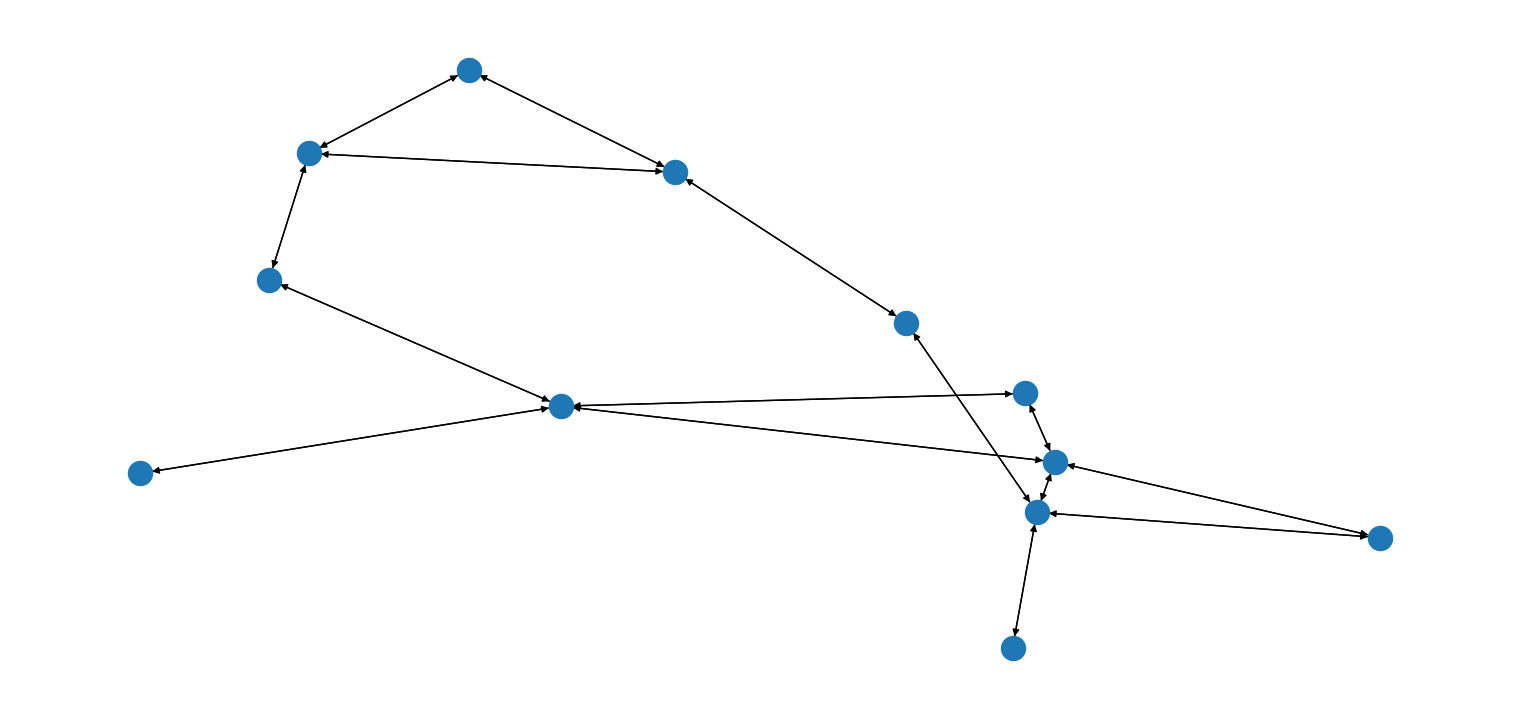

In [6]:
plot_net(g)

For the purposes of this demo the values of the weights are irrelevant, in particular the weights for the bidirectional edges do no not have to be identical

### Select link(s) as proxy for node pairs for local attachement
Links are selected with a probability corresponding to their weight. For this, we reormalize all edge weights over the ensemble of all edges

In [7]:
norm_edgeweights = g.edata['w']/g.edata['w'].sum()


We can then define the number of edges to select and draw based on the normlaized edgeweights

In [8]:
nsamp =4 # number of samples

The selection index is then given by

In [9]:
sel_idx = norm_edgeweights.flatten().multinomial(num_samples=nsamp,replacement=False)

Using the `.edges()` builtin we can retrieve the src and  dst node ids, as well as the edge ids

In [10]:
src_ids = g.edges('all')[0][sel_idx] # src node id

In [11]:
dst_ids = g.edges('all')[1][sel_idx] # dst node id

In [12]:
e_ids = g.edges('all')[2][sel_idx] # edge id

In [13]:
selected_edges = torch.vstack((src_ids,dst_ids,e_ids))


In [14]:
selected_edges

tensor([[ 0,  5,  4,  2],
        [ 6,  4,  9,  6],
        [ 1, 13, 12,  6]])

### Utility functions

In [15]:
def attached_nodes(srcid,dstid,graph):
    """
    find all neighbours of the dst node of an edge, removing src node as may result from bidirectional edges
    """
    successors_ = graph.successors(dstid)
    successors = successors_[successors_!=srcid]
    return successors

    

In [16]:
def existing_connections(srcid,nodelist,graph):
    """
    identify all exisitng links between a src node and a list nodes 
    """
    existing_connection=graph.has_edges_between(srcid,nodelist)
    return existing_connection

In [17]:
def select_attachment(srcid,dstid,nodes_attached_dst,connections,graph):
    """
    select possible attachments by identifying neighbours of dst node of srcc-dst edge, discarding exisiting connections and selecting a
    local attachement dst by weighted draw form the normalized weight distribution of all neigbouring nodes
    """
    possible_link_dst = nodes_attached_dst[connections==False]
    parent_link_ids = graph.edge_ids(torch.ones_like(possible_link_dst,dtype=int)*dstid,possible_link_dst)
    parent_link_weight = graph.edges[parent_link_ids].data['w']
    parent_link_weight_norm = parent_link_weight/parent_link_weight.sum()
    select = parent_link_weight_norm.flatten().multinomial(num_samples=1,replacement=True)
    return possible_link_dst[select]

    

In [18]:
def create_local_attachment(srcid,dstid,p_attach,graph):
    """
    create a loal attachement (FoF connection between a src node and a FoF node with a given probability
    """
    dst_attached_nodes = attached_nodes(srcid,dstid,graph)
    if dst_attached_nodes.numel() != 0: # check for isolated nodes
        connections = existing_connections(srcid,dst_attached_nodes,graph)
        if torch.all(connections): # check for saturated naeighbourhoods
            print('saturated')
            return
        else:
            local_attach_dst = select_attachment(srcid,dstid,dst_attached_nodes, connections, graph)
            if p_attach > torch.rand(1):
                print(f"creating bidirectional link between nodes {srcid} (src) and {dstid} (dst)") 
                g.add_edges(srcid,local_attach_dst)
                g.add_edges(local_attach_dst,srcid)
    else:
        print(f"dst node {dstid} is an isolated node")
        return

In [19]:
p_attach = 1.

In [20]:
for i in range(len(src_ids)):
    print(i)
    srcid = selected_edges[:,i][0]
    dstid = selected_edges[:,i][1]
    create_local_attachment(srcid,dstid,p_attach,g)
    

0
creating bidirectional link between nodes 0 (src) and 6 (dst)
1
creating bidirectional link between nodes 5 (src) and 4 (dst)
2
creating bidirectional link between nodes 4 (src) and 9 (dst)
3
creating bidirectional link between nodes 2 (src) and 6 (dst)


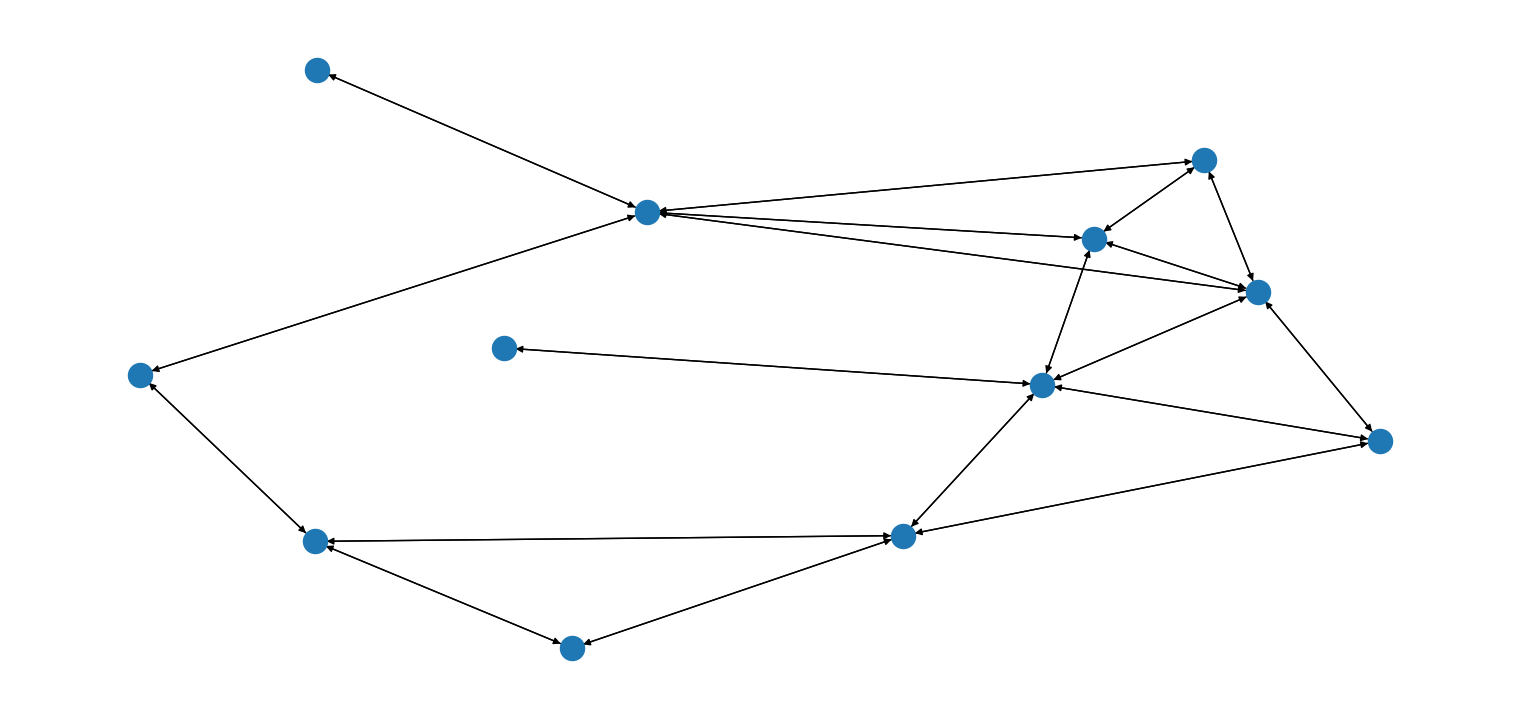

In [21]:
plot_net(g)